In [1]:
!pip install --upgrade pip --quiet
!pip install cvxopt --quiet


[notice] A new release of pip is available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
#import some useful packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, schedule
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%config InlineBackend.figure_formats = ['svg']
import time 
import os
import csv

import warnings
warnings.filterwarnings('ignore')

import os
import csv

IBMQ.save_account('5baae95ab0c4f46ba156eb0909ff9b8b54fffc1c24b7366190b85d6b2293ed9cac1f51cfa4f008890fcdd9f3871a23d904af20a6812bcf9fedb7fd982d968ca1', overwrite=True)
provider = IBMQ.load_account()

provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 0


In [6]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.25.3', 'qiskit': '0.44.3', 'qiskit-aer': '0.12.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': '0.6.2', 'qiskit-finance': None, 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.6.1'}

In [7]:
provider.backend.credentials

Traceback (most recent call last):
  Cell In[7], line 1
    provider.backend.credentials
AttributeError: 'IBMBackendService' object has no attribute 'credentials'

Use %tb to get the full traceback.


In [4]:
#get information about backend
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [4]:
#hyperparameters
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar

pi = np.pi
cos = np.cos
sin = np.sin
NUM_SHOTS = 1024
scale_factor = 1e-7

In [12]:
# amp01 = 0.4150600327660328
amp_halfpi_01 = 0.12408455503224007
amp_halfpi_12 = 0.1274492989718845
amp01 = 2*amp_halfpi_01
amp12 = 2*amp_halfpi_12
dur12 = 96
sig12 = dur12/4
dur01 = 96
sig01 = dur01/4

In [45]:
def S01_sched(phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(01)}$') as S01_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f01, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur01,
                                      amp=amp_halfpi_01,
                                      sigma=sig01,
                                      name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

    return S01_pulse

def S12_sched(phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(12)}$') as S12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur12,
                                      amp=amp_halfpi_12,
                                      sigma=sig12,
                                      name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

    return S12_pulse

# Generalize phase tracking protocol with many jobs

In [49]:
#some useful pulse
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as xpi12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=dur12,
                            amp=amp12,
                            sigma=sig12,
                            name=r'$X_{\pi}^{(12)}$'), drive_chan)

    
#some useful pulse
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as xpi01_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=dur01,
                            amp=amp01,
                            sigma=sig01,
                            name=r'$X_{\pi}^{(01)}$'), drive_chan)



In [52]:
Xpi01 = Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = Gate("$X_{\pi}^{12}$", 1, [])


zero = QuantumCircuit(1, 1)
zero.measure(0, 0)

one = QuantumCircuit(1, 1)
one.x(0)
one.measure(0, 0)

two = QuantumCircuit(1, 1)
two.x(0)
two.append(Xpi12, [0])
two.measure(0, 0)
two.add_calibration(Xpi12, (0,), xpi12_sched, [])

discr_circ = [zero, one, two]

exp_circs = []
phi_arr = np.linspace(0, np.pi, 97)
phi = Parameter('phi')
with pulse.build(backend=backend, default_alignment='sequential',
                 name=r'$S^{(01)}(\phi)$') as phase_shift_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(phi, drive_chan):
        pulse.play(pulse.Gaussian(duration=dur01,
                                  amp=amp_halfpi_01,
                                  sigma=sig01,
                                  name=r'$X_{\pi/2}^{(01)}$'), drive_chan)
phase_shift_gate = Gate("phase shift", 1, [phi])
x01_halfpi = Gate("$X_{\pi/2}^{01}$", 1, [])

qc_phase_shift = QuantumCircuit(1, 1)
qc_phase_shift.append(x01_halfpi, [0])
qc_phase_shift.append(phase_shift_gate, [0])
qc_phase_shift.measure(qubit, 0)
qc_phase_shift.add_calibration(phase_shift_gate, (0,), phase_shift_sched, [phi])
qc_phase_shift.add_calibration(x01_halfpi, (0,), S01_sched(0), [])


exp_phase_shift_circs = [qc_phase_shift.assign_parameters({phi: a}, inplace=False) for a in phi_arr]

exp_circs = discr_circ + exp_phase_shift_circs

print(len(exp_circs))

100


In [ ]:
phase_shift_job = backend.run(exp_circs, 
                          meas_level=1, 
                          meas_return='single', 
                          shots=1024)
job_monitor(phase_shift_job)
phase_shift_job.job_id()

Job Status: job is queued (7) [Est. wait time: 1 hrs 39 min] 

In [5]:
def Z01(phi):
    return np.array([[np.exp(-1j * phi), 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

def Z12(phi):
    return np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, np.exp(1j * phi)]])

def X01(theta):
    return np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2), 0],
                     [-1j * np.sin(theta / 2), np.cos(theta / 2), 0],
                     [0, 0, 1]])


def X12(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta / 2), -1j * np.sin(theta / 2)],
                     [0, -1j * np.sin(theta / 2), np.cos(theta / 2)]])

def population_model(phi, alpha, beta, gamma):
    ground = np.array([[1], [0], [0]])
    psi =  Z12(alpha) @ Z01(-phi + beta) @ X01(np.pi/2) @ Z01(phi + gamma)\
           @ Z12(alpha) @ Z01(beta) @ X01(np.pi/2) @ Z01(gamma) @ ground
    return [np.abs(psi[0][0])**2, np.abs(psi[1][0])**2, np.abs(psi[2][0])**2]

def loss_func(param, phi, p_exp, N_data = 97):
  p_model = [population_model(phi[i], *param) for i in range(N_data)]
  return mean_squared_error(p_model, p_exp, squared = False)

In [6]:
NUM_SHOTS = 1024


#some useful function
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

#define a pulse rotating theta around n-axis in subspace 0-1 and 1-2

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def discriminate(data) :
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    zero_data_reshaped = reshape_complex_vec(zero_data)
    one_data_reshaped = reshape_complex_vec(one_data)
    two_data_reshaped = reshape_complex_vec(two_data)
    IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
    state_012 = np.zeros(NUM_SHOTS)  
    state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
    state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
    IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.3)
    LDA_012 = LinearDiscriminantAnalysis()
    LDA_012.fit(IQ_012_train, state_012_train)
    return LDA_012

def count(data, discriminator):
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
        #print('predicting', j, end='\r')
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

from cvxopt import matrix, solvers
def mitigated_population(p, C):
    P = matrix(np.transpose(C).dot(C))
    q = matrix(-np.transpose(p).dot(C))
    G = matrix([[-1.0,0.0,0.0],[0.0,-1.0,0.0],[0.0,0.0,-1.0]])
    h = matrix([0.0, 0.0, 0.0])
    A = matrix([1.0, 1.0, 1.0], (1,3))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    sol=solvers.qp(P, q, G, h, A, b)
    # return np.asarray(sol['x'])
    return np.array([e for e in sol['x']])

def get_population(data, discriminator):
    drag_values = count(data, discriminator)
    return np.asarray([[val['0']/NUM_SHOTS, val['1']/NUM_SHOTS, val['2']/NUM_SHOTS] for val in drag_values])

def get_mitigated_population(data, discriminator, confusion_matrix):
    population = get_population(data, discriminator)
    mitigated = [mitigated_population(pop, confusion_matrix) for pop in population]
    return np.asarray(mitigated)

def IQ_012_plot(discrim_data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = discrim_data[0]
    one_data = discrim_data[1]
    two_data = discrim_data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)
    


#l

In [7]:
from scipy.optimize import minimize

def phase_tracking(job_id):
    
    job = provider.backend.retrieve_job(job_id)
    data = get_job_data(job, average = False)
    discrim_data = data[:3]
    exp_data = data[3:]
    
    # IQ_012_plot(discrim_data)
    
    LDA_012 = discriminate(discrim_data)

    discr_data = count(discrim_data, LDA_012)
    #confusion matrix
    conf_mat = [[discr_data[i]['0'] / NUM_SHOTS, discr_data[i]['1'] / NUM_SHOTS, discr_data[i]['2'] / NUM_SHOTS] for i in
                    range(np.shape(discr_data)[0])] 
    print(conf_mat)
    
    population = get_mitigated_population(exp_data, LDA_012, conf_mat)

    N_seed = 100
    N_data = 97
    loss = 200
    x_optimum = 0
    phi_arr = np.linspace(0, np.pi, 97)
    for i in range(N_seed):
        # print(i)
        x_initial = np.random.default_rng().uniform(-np.pi/10, np.pi/10, 3)
        # eps = 0.15
        # x_initial = [np.random.default_rng().uniform(-np.pi/4 - eps, -np.pi/4 + eps), np.random.default_rng().uniform(-eps, eps), np.random.default_rng().uniform(np.pi/4 - eps, np.pi/4 + eps)]
        res = minimize(loss_func, x0 = x_initial, args = (phi_arr, population, N_data))
        if(res.fun < loss):
            loss = res.fun
            x_optimum = res.x%(2*pi)

    
    param = np.array(x_optimum)
    model_population = [population_model(phi_arr[i], *param)  for i in range(N_data)]
    plt.scatter(range(N_data), [p[0] for p in population])
    plt.scatter(range(N_data), [p[1] for p in population])
    plt.scatter(range(N_data), [p[2] for p in population])
    plt.ylim(0, 1)

    fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 5), dpi=100)
    plt.setp(axs.flat, aspect=1.0, adjustable='box')
    plt.subplots_adjust(top=1, hspace=0)
    fig.tight_layout()
    plt.suptitle(str(x_optimum), weight = 'bold')
    colors = ['r', 'g', 'b']
    r2_arr = []
    for i in range(3):
        p_model = [p[i] for p in model_population]
        p_exp = [p[i] for p in population]
        r2_arr.append(np.round(r2_score(p_model, p_exp), 3))
        axs[i].scatter(p_model, p_exp, color = colors[i])
        xplt = np.linspace(0, 1, 1000)
        axs[i].plot(xplt, xplt, color = 'black')
        axs[i].axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
        axs[i].set_title('r^2 = ' + str(np.round(r2_score(p_model, p_exp), 3)) )
    return x_optimum, r2_arr, loss
    # return x_optimum

[[0.9716796875, 0.0263671875, 0.001953125], [0.0205078125, 0.8291015625, 0.150390625], [0.0126953125, 0.2685546875, 0.71875]]


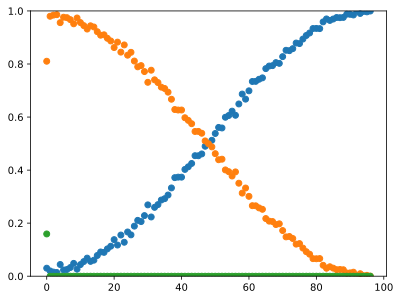

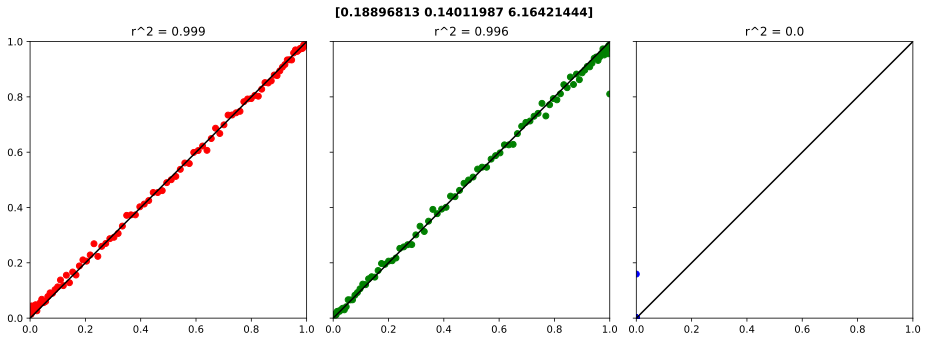

In [8]:
res = phase_tracking('cp5xzqp2zy6g008xs1d0')

In [28]:
a = res[0]
a[1] - 2*np.pi

-0.03972665878501669